# HexaCopter
Simulation model of the hexacopter.
Motion of the hexacopter follows to the Linerized Equation of Motion:
$$\ddot{a}=E\omega+g$$
        where $a$ is the state vector: $s = [\begin{matrix}z & \phi & \theta & \psi \end{matrix}]$, $z$ z is the vertical position [m] with downward direction, $\phi$, $\theta$ and $\psi$ are the body angles [rad] with respect to the x, y, z axis respectively, $E$ is a actuator mixing matrix which describes how the actuators(rotors) mix to affect the controllable degrees of freedom, $\omega$ is the vector of rotor speeds [rad/s] and $g$ is gravity acceleration.
Integration of the equation for updating the state vector is calculated with the Runge-kutta method.

In [147]:
import numpy as np

class Hxcopter:
    g = 9.81 # gravity coefficient [ m/s^2]
    m = 2.1 # mass [kg]
    L = 0.34 # Distance of rotor from CG [m]
    I = (0.061, 0.060, 0.12) # moments of inertia (Ixx, Iyy, Izz) [kg*m^2]
    kT = 2.3 * 10 ** (-5) # propeller thrust [rad^2/sec^2]
    kQ = 7 * 10 ** (-7) # torque coefficients [rad^2/sec^2]
    
    def __init__(self, dt, omega0):
        self.dt = dt # simulation time step [sec]
        self.rotors = [Rotor(omega0, dt),
                                Rotor(omega0, dt),
                                Rotor(omega0, dt),
                                Rotor(omega0, dt),
                                Rotor(omega0, dt),
                                Rotor(omega0, dt)]
        self.state = np.array([0.0, 0.0, 0.0, 0.0]) # altitude [m], roll, pitch, yaw [rad]
        self.dstate = np.array([0.0, 0.0, 0.0, 0.0]) # vertical speed [m/s], roll, pitch, yaw speed [rad/sec]
        
        # Matrix of EOM
        Ew = (- self.kT / self.m) * np.array([1.0, 1.0, 1.0, 1.0, 1.0, 1.0])
        Ep = (1.73 * self.L * self.kT / 2 / self.I[0]) * np.array([0, -1.0, -1.0, 0, 1.0, 1.0])
        Eq = (self.L * self.kT / self.I[1]) * np.array([1.0, 0.5, -0.5, -1.0, -0.5, 0.5])
        Er = (self.kQ / self.I[2]) * np.array([-1.0, 1.0, -1.0, 1.0, -1.0, 1.0, ])
        self.E = np.array([Ew, Ep, Eq, Er])
    
    def get_state(self):
        return self.state
    
    def get_velosity(self):
        return self.dstate
    
    def func(self, x, y):
        o = np.array([0, 0, 0, 0, 0, 0])
        for i in range(6):
            o[i] = self.rotors[i].o
        dx = y
        dy = self.E.dot(o * o) + np.array([self.g, 0.0, 0.0, 0.0])
        return dx, dy
    
    def update(self):
        for r in self.rotors:
            r.update()
        kx1, ky1= self.func(self.state, self.dstate)
        kx2, ky2 = self.func(self.state + kx1 * self.dt / 2, self.dstate + ky1 * self.dt / 2)
        kx3, ky3 = self.func(self.state + kx2 * self.dt / 2, self.dstate + ky2 * self.dt / 2)
        kx4, ky4 = self.func(self.state + kx3 * self.dt, self.dstate + ky3 * self.dt)
        self.dstate += (ky1 + 2 * ky2 + 2 * ky3 + ky4) * self.dt / 6
        self.state += (kx1 + 2 * kx2 + 2 * kx3 + kx4) * self.dt / 6
        return self.state
    
    def set_rotor_speed(self, cmds):
        for i in range(6):
            self.rotors[i].set_speed(cmds[i])

## Rotor
Simulation model of the rotor.
The rotor speed is assumed that bandwidth of the controlled motor/propeller pair can be modeled by as simple lag filter as below:
$$\dot{\omega}=\frac{1}{\tau}(\omega_{cmd}-\omega)$$
where $\omega$ is the rotor speed [rad/s], $\tau$ is a time constant and $\omega_{cmd}$ is the speed commond.

In [3]:
class Rotor:
    tau = 0.15 # motor time constant
    
    def __init__(self, omega0, dt):
        self.o = omega0 # omega = rotor speed
        self.cmd = omega0 # speed commond
        self.dt = dt # simulation time step width
    
    def func(self, o):
        return (self.cmd - o) / self.tau
    
    def domega(self):
        k1 = self.func(self.o)
        k2 = self.func(self.o + k1 * self.dt / 2)
        k3 = self.func(self.o + k2 * self.dt / 2)
        k4 = self.func(self.o + k3 * self.dt)
        return (k1 + 2 * k2 + 2 * k3 + k4) * self.dt / 6
    
    def update(self):
        self.o += self.domega()
        return self.o
    
    def set_speed(self, cmd):
        self.cmd = cmd

## PID
Basic PID unit.

In [17]:
class PID:
    def __init__(self, Kp, Ki, Kd):
        self.Kp = Kp
        self.Ki = Ki
        self.Kd = Kd
        self.ei = 0.0
        self.pe = 0.0
    
    def update(self, x, y):
        e = x - y
        self.ei = e
        ed = e - self.pe
        u = self.Kp * e + self.Ki * self.ei + self.Kd * ed
        self.pe = e
        return u

## PID controller for Hexa Copter
The linearized transfer function of the hexacopter is written as below:
$$\bigg\{
\begin{array}{l}
\omega=\frac{1}{\tau s+1}\omega_{cmd}\\
a=2\omega_0E\omega
\end{array}
$$

In [98]:
class HxController:
    g = 9.81 # gravity coefficient [ m/s^2]
    m = 2.1 # mass [kg]
    L = 0.34 # Distance of rotor from CG [m]
    I = (0.061, 0.060, 0.12) # moments of inertia (Ixx, Iyy, Izz) [kg*m^2]
    kT = 2.3 * 10 ** (-5) # propeller thrust [rad^2/sec^2]
    kQ = 7 * 10 ** (-7) # torque coefficients [rad^2/sec^2]
    
    def __init__(self, pids):
        self.pids = pids
        ew = - self.m / 6 / self.kT
        ep = 1.73 * self.I[0] / 6 / self.kT
        eq = self.I[1] / 3 / self.L / self.kT
        er = self.I[2] / 6 / self.kQ
        e1 = np.array([ew, 0, eq, - er])
        e2 = np.array([ew, ep, eq / 2, er])
        e3 = np.array([ew, ep, - eq / 2, - er])
        e4 = np.array([ew, 0, - eq, er])
        e5 = np.array([ew, - ep, - eq / 2, - er])
        e6 = np.array([ew, - ep, eq / 2, er])
        self.Einv = np.array([e1, e2, e3, e4, e5, e6])
        
    def update(self, cmds, states):
        us = np.array([0.0, 0.0, 0.0, 0.0]) 
        for i in range(4):
            x = cmds[i]
            y = states[i]
            us[i] = pids[i].update(x, y)
        return self.Einv.dot(us)

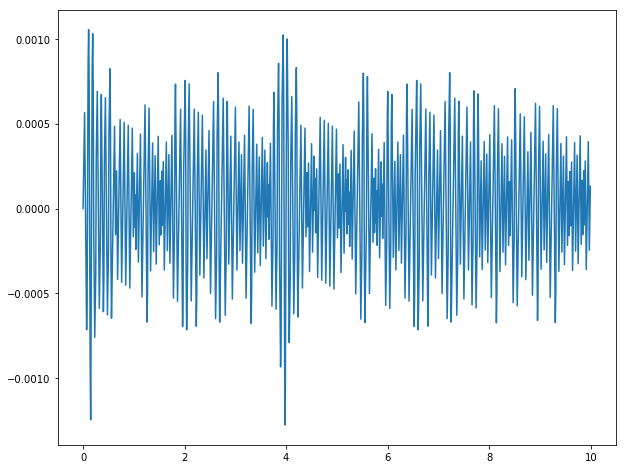

In [146]:
import matplotlib.pyplot as plt

# Display plots inline and change default figure size
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)

# simulation parameters
dt = 0.01 # simulation time step width [sec]
runtime = 10 # simulation time [sec]
num_steps = int(runtime / dt) # required number of simulation step

# plant setting
omega0 = 386.4 # initial rotor speed [rpm]
hx = Hxcopter(dt, omega0)

# controller setting
pids = [PID(1.0, 0.0, 0.0), PID(0.0, 0.0, 0.0), PID(0.0, 0.0, 0.0), PID(0.0, 0.0, 0.0)]
ctr = HxController( pids )

cmds = np.array([0.0, 0.0, 0.0, 0.0])
data = np.zeros(num_steps)

for i in range(num_steps):
    if (i == 100):
        cmds = np.array([0.0, 0.0, 0.0, 0.0])
    state = hx.get_state()
    state = hx.dstate
    u = ctr.update(cmds, state) + np.array([omega0, omega0, omega0, omega0, omega0, omega0])
    hx.set_rotor_speed(u)
    data[i] = state[0]
    hx.update()

t = np.arange(0, runtime, dt)
plt.plot(t, data)